In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import copy
import itertools
import os
import random

import yaml

In [ ]:
subjects = [f"S{i:02d}" for i in range(1, 9)]

random.seed(100)
random.shuffle(subjects)
all_combos = []

# Pick 3 subjects randomly as train and valid sets
for group in itertools.combinations(subjects, 3):
    test_group = sorted([s for s in subjects if s not in group])
    for val_group in group:  # pick a subject as validation
        train_group = sorted([s for s in group if s not in val_group])
        all_combos.append((tuple(train_group), tuple([val_group]), tuple(test_group)))

print(f"Total combinations: {len(all_combos)}")  # Should be 168 combinations

with open("configs/reproduce/virenet_infant_to_infant_0_of.yaml", 'r') as f:
    base_config = yaml.safe_load(f)

base_preprocess = base_config['TRAIN']['DATA']['PREPROCESS']
base_config['VALID']['DATA']['PREPROCESS'] = base_preprocess
base_config['TEST']['DATA']['PREPROCESS'] = base_preprocess

# Generate YAML files for each combo
output_dir = "configs/reproducing_test"
os.makedirs(output_dir, exist_ok=True)

for idx, (train_group, val_group, test_group) in enumerate(all_combos):
    yaml_data = copy.deepcopy(base_config)

    # update groups
    yaml_data['TRAIN']['DATA']['SPLIT_SUBJECTS'] = list(train_group)
    yaml_data['VALID']['DATA']['SPLIT_SUBJECTS'] = list(val_group)
    yaml_data['TEST']['DATA']['SPLIT_SUBJECTS'] = list(test_group)

    # update NAME for uniqueness
    yaml_name = f"virenet_infant_to_infant_test_{idx}"
    yaml_data['NAME'] = yaml_name

    # save file
    file_path = os.path.join(output_dir, f"{yaml_name}.yaml")
    with open(file_path, 'w') as f:
        yaml.dump(yaml_data, f, sort_keys=False)


In [140]:
air125_combo_test_result = pd.read_csv("results/air125_all_combo_results.csv")
air125_combo_test_result.sort_values(by=['test_mae_mean'], inplace=True)
air125_combo_test_result.head()

,Name,State,Notes,User,Tags,Created,Runtime,Sweep,DATA_PATH.AIR_125,DATA_PATH.AIR_400,...,test_mse_mean,test_mse_std,test_pearson_r,test_pearson_r_mean,test_pearson_r_std,test_rmse,test_rmse_mean,test_rmse_std,train_loss,val_loss
55,virenet_infant_to_infant_test_54,finished,-,NaN,NaN,2025-09-19T05:48:54.000Z,96,NaN,/projects/song.liy/datasets/AIR_125,/projects/song.liy/datasets/AIR_400,...,18.885275,0,0.817771,0.817771,0,4.345719,4.345719,0,0.065958,0.007323
155,virenet_infant_to_infant_test_26,finished,-,NaN,NaN,2025-09-19T04:57:35.000Z,86,NaN,/projects/song.liy/datasets/AIR_125,/projects/song.liy/datasets/AIR_400,...,22.966536,0,0.711521,0.711521,0,4.792341,4.792341,0,0.091462,0.002134
39,virenet_infant_to_infant_test_58,finished,-,NaN,NaN,2025-09-19T05:55:41.000Z,92,NaN,/projects/song.liy/datasets/AIR_125,/projects/song.liy/datasets/AIR_400,...,19.326981,0,0.799984,0.799984,0,4.396246,4.396246,0,0.081126,0.001662
118,virenet_infant_to_infant_test_39,finished,-,NaN,NaN,2025-09-19T05:20:31.000Z,98,NaN,/projects/song.liy/datasets/AIR_125,/projects/song.liy/datasets/AIR_400,...,36.786537,0,0.726791,0.726791,0,6.065191,6.065191,0,0.031306,0.005119
108,virenet_infant_to_infant_test_41,finished,-,NaN,NaN,2025-09-19T05:25:43.000Z,99,NaN,/projects/song.liy/datasets/AIR_125,/projects/song.liy/datasets/AIR_400,...,31.335665,0,0.761937,0.761937,0,5.597827,5.597827,0,0.060673,0.009590


In [342]:
import numpy as np
import json


def rainboxplot(df, reproduce_combo, violin_side, output_path):
    """
    data_by_group: dict[str, array_like] mapping group label -> 1D array of values (e.g., MAEs)
    """
    values = np.asarray(df['test_mae']).ravel()
    fig, ax = plt.subplots(figsize=(7, 4), dpi=300)

    # x-limits
    xpad = 0.08 * (np.max(values) - np.min(values) + 1e-9)
    xlow, xhigh = np.min(values) - xpad, np.max(values) + xpad - 0.6
    violin_y = 1.3
    box_y = 1.0
    violin_height = 0.7
    light_c = '#d5e3ee'
    dark_c = '#7b99b9'
    
    vp = ax.violinplot(
        values, 
        positions=[violin_y], 
        widths=violin_height,
        vert=False,
        showmeans=False, 
        showmedians=False, 
        showextrema=False,  
    )
    for body in vp['bodies']:
        body.set_facecolor(dark_c)
        body.set_edgecolor('none')
        body.set_alpha(0.5)
    
        # Clip to half
        if violin_side == "top":
            rect = plt.Rectangle(
                (xlow, violin_y), 
                (xhigh - xlow), 
                violin_height /2,
                transform=ax.transData
            )
        else:
            rect = plt.Rectangle(
                (xlow, violin_y - violin_height/2), 
                (xhigh - xlow), 
                violin_height /2,
                transform=ax.transData
            )
        body.set_clip_path(rect)

    # Boxplot
    bp = ax.boxplot(
        values, 
        positions=[box_y], 
        widths=0.4, 
        vert=False,
        showmeans=True,
        meanline=True,
        patch_artist=True,
        showfliers=False,
        whis=1.5
        
    )
    for patch in bp['boxes']:
        patch.set_facecolor(light_c)
        patch.set_edgecolor(dark_c)
        patch.set_linewidth(1.0)
    for line in bp['whiskers'] + bp['caps'] + bp['means'] + bp['medians']:
        line.set_color(dark_c)
        line.set_linewidth(1.0)

    # Jittered points
    rng = np.random.default_rng(42)  # fixed for reproducibility
    yj = box_y + rng.uniform(-0.2, 0.2, size=len(values))
    ax.scatter(
        values, 
        yj, 
        s=18, 
        facecolor=light_c, 
        edgecolor=dark_c,
        alpha=0.8,
        linewidth=1,
        zorder=3)

    # Mean label
    mu = float(np.mean(values))
    ax.text(mu, violin_y-0.08, f"mean={mu:.2f}", ha='center', va="bottom", fontsize=10, color="black")
    
    # Counts label
    count = len(values)
    ax.text(max(values) - 0.8, 1.2, f"n={count}", ha='center', va="bottom", fontsize=10, color=dark_c)
    
    # Reproduce combo
    train_set, valid_set = reproduce_combo
    mask = df.apply(
        lambda row: json.loads(str(row["TRAIN.DATA"]))[0]["SPLIT_SUBJECTS"] == train_set
                    and json.loads(str(row["VALID.DATA"]))[0]["SPLIT_SUBJECTS"] == valid_set,
        axis=1
    )
    mae_manne = 2.91
    mae_replica = df.loc[mask, "test_mae"].values[0]
    ax.scatter(
        mae_replica,
        yj[mask],
        s=50,
        marker="D",   # diamond
        facecolor="steelblue",
        edgecolor="black",
        linewidth=1.2,
        zorder=5,
        label="Replication of Manne et al."
    )
    ax.scatter(
        mae_manne,
        yj[mask],
        s=50,
        marker="D",   # diamond
        facecolor="crimson",
        edgecolor="black",
        linewidth=1.2,
        zorder=5,
        label="Manne et al."
    )
    def percentile_of_value(a, v):
        return 100.0 * (np.sum(a <= v) / len(a))

    p_manne = percentile_of_value(values, mae_manne)
    p_repr  = percentile_of_value(values, mae_replica)
    ax.axvline(mae_manne, color="crimson", lw=1.2, ls="--", alpha=0.7)
    ax.axvline(mae_replica, color="steelblue", lw=1.2, ls="--", alpha=0.7)
    ax.text(mae_manne, box_y-0.4, f"MAE={mae_manne} \nP={p_manne/100:.2f} ", color="crimson", ha="right", va="bottom", fontsize=10)
    ax.text(mae_replica, box_y-0.4, f" MAE={mae_replica:.2f}\n P={p_repr/100:.2f}", color="steelblue", ha="left", va="bottom", fontsize=10)

    # cosmetics
    ax.set_xlim(xlow, xhigh)
    ax.set_ylim(box_y - 0.45, violin_y + 0.45)
    ax.set_yticks([])
    ax.set_xlabel("MAE (BPM)", fontsize=12)
    ax.tick_params(labelsize=12)
    # ax.grid(axis='x', linestyle=':', alpha=0.6)
    
    ax.legend(loc="lower right", frameon=True, prop={'size': 10})
    
    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    plt.show()

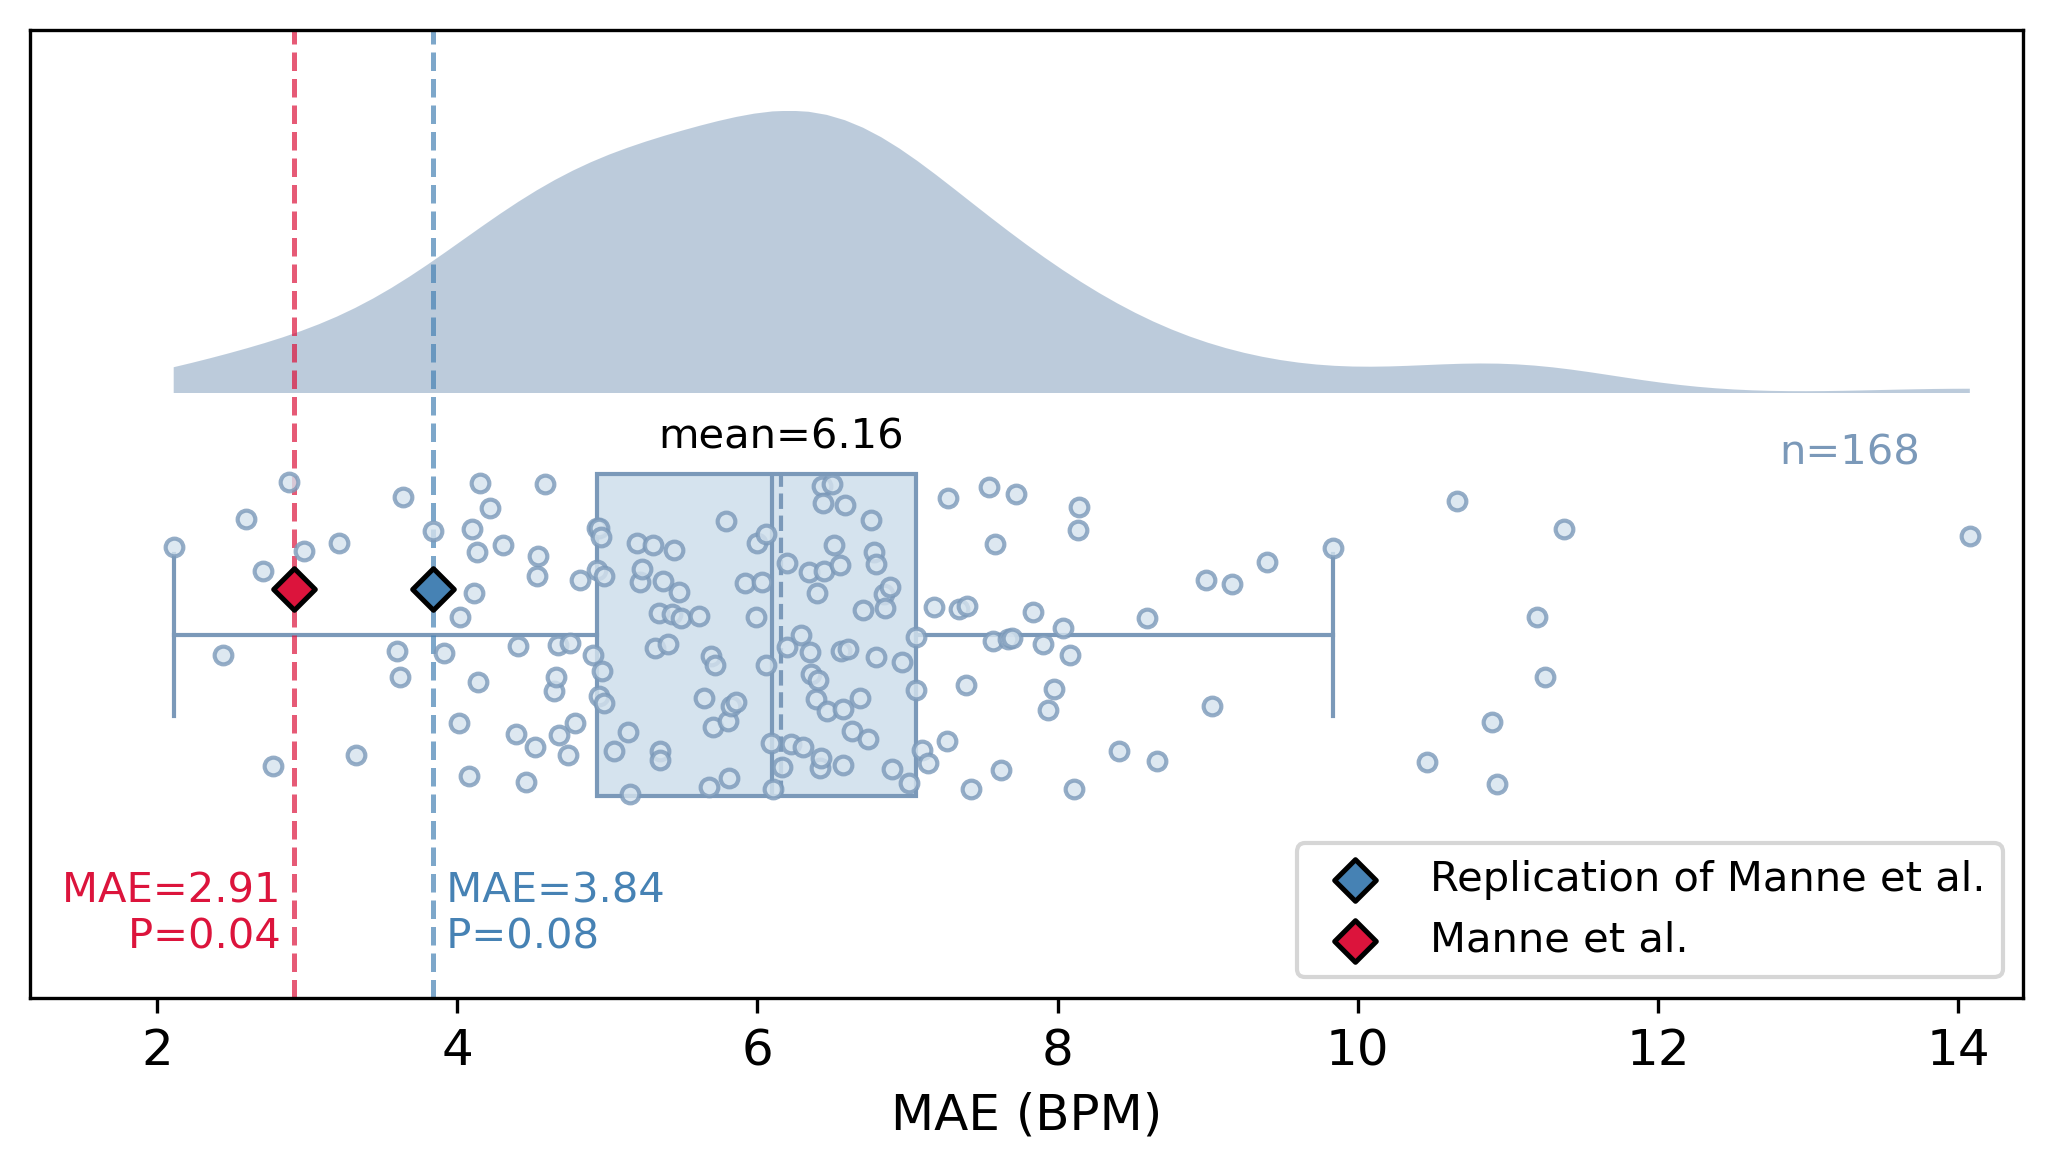

In [343]:
rainboxplot(air125_combo_test_result, reproduce_combo=(["S01", "S03"], ["S06"]), violin_side="top", output_path="results/air125_all_comb_results.png")